# 01.2b: Shell vs. Offset Blob Test

**Goal:** Determine if the token cloud is a spherically symmetric shell centered at the origin, or an offset Gaussian blob.

The radial distribution from 01.2a shows tokens clustered around ~1.07 gamma units from the origin. But this could mean two different things:

1. **Shell hypothesis:** Tokens form a spherical shell of radius ~1.07, centered at origin, with a void in the middle
2. **Offset blob hypothesis:** Tokens form a Gaussian-ish blob whose center is displaced ~1.07 units from the origin in some particular direction

## The Test

We'll project all tokens onto random unit directions and plot **signed** histograms:

- **If shell:** Projections in all directions should be symmetric around zero (tokens equally distributed on both sides)
- **If offset blob:** One particular direction will show strong asymmetry (most tokens on one side of zero)

## Mathematical Background

For a random unit vector **u** (||u|| = 1), project each token onto it:

$$p_i = \gamma'_i \cdot u$$

This gives a **signed** scalar for each token. If the cloud is spherically symmetric around the origin, the distribution of p should be symmetric around zero for **any** choice of u.

## Parameters

In [16]:
TENSOR_DIR = "../data/tensors"
RANDOM_SEED = 42
COLORMAP = 'inferno'

NUM_RANDOM_DIRECTIONS = 6  # Test this many random directions
NUM_BINS = 100  # Histogram bins

## Imports

In [17]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

# Set random seed
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Centered Gamma

In [18]:
gamma_centered_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_centered = load_file(gamma_centered_path)['gamma_centered']

N, d = gamma_centered.shape

print(f"Loaded γ' (gamma_centered):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")

Loaded γ' (gamma_centered):
  Tokens: 151,936
  Dimensions: 2,560


## Step 2: Verify Centering

Quick sanity check: is the mean actually at the origin?

In [19]:
mean = gamma_centered.mean(dim=0)
mean_norm = mean.norm().item()

print(f"Mean vector norm: {mean_norm:.2e}")
print(f"Should be very close to zero if properly centered.")

if mean_norm > 1e-5:
    print(f"\n⚠️ WARNING: Mean norm is suspiciously large! Centering may have failed.")
else:
    print(f"\n✓ Centering confirmed: mean is at origin.")

Mean vector norm: 3.95e-08
Should be very close to zero if properly centered.

✓ Centering confirmed: mean is at origin.


## Step 3: Generate Random Unit Directions

In [20]:
# Generate random unit vectors
random_directions = torch.randn(NUM_RANDOM_DIRECTIONS, d)
random_directions = random_directions / random_directions.norm(dim=1, keepdim=True)

print(f"Generated {NUM_RANDOM_DIRECTIONS} random unit directions in {d}D space")
print(f"\nVerifying they're unit vectors:")
for i, direction in enumerate(random_directions):
    print(f"  Direction {i}: norm = {direction.norm().item():.6f}")

Generated 6 random unit directions in 2560D space

Verifying they're unit vectors:
  Direction 0: norm = 1.000000
  Direction 1: norm = 1.000000
  Direction 2: norm = 1.000000
  Direction 3: norm = 1.000000
  Direction 4: norm = 1.000000
  Direction 5: norm = 1.000000


## Step 4: Project Tokens onto Each Direction

In [21]:
# Project all tokens onto all directions at once
# Shape: (N, NUM_RANDOM_DIRECTIONS)
projections = gamma_centered @ random_directions.T

print(f"Computed projections:")
print(f"  Shape: {projections.shape}")
print(f"  (Each column is one direction, each row is one token)")

Computed projections:
  Shape: torch.Size([151936, 6])
  (Each column is one direction, each row is one token)


## Step 5: Plot Signed Histograms for Each Direction

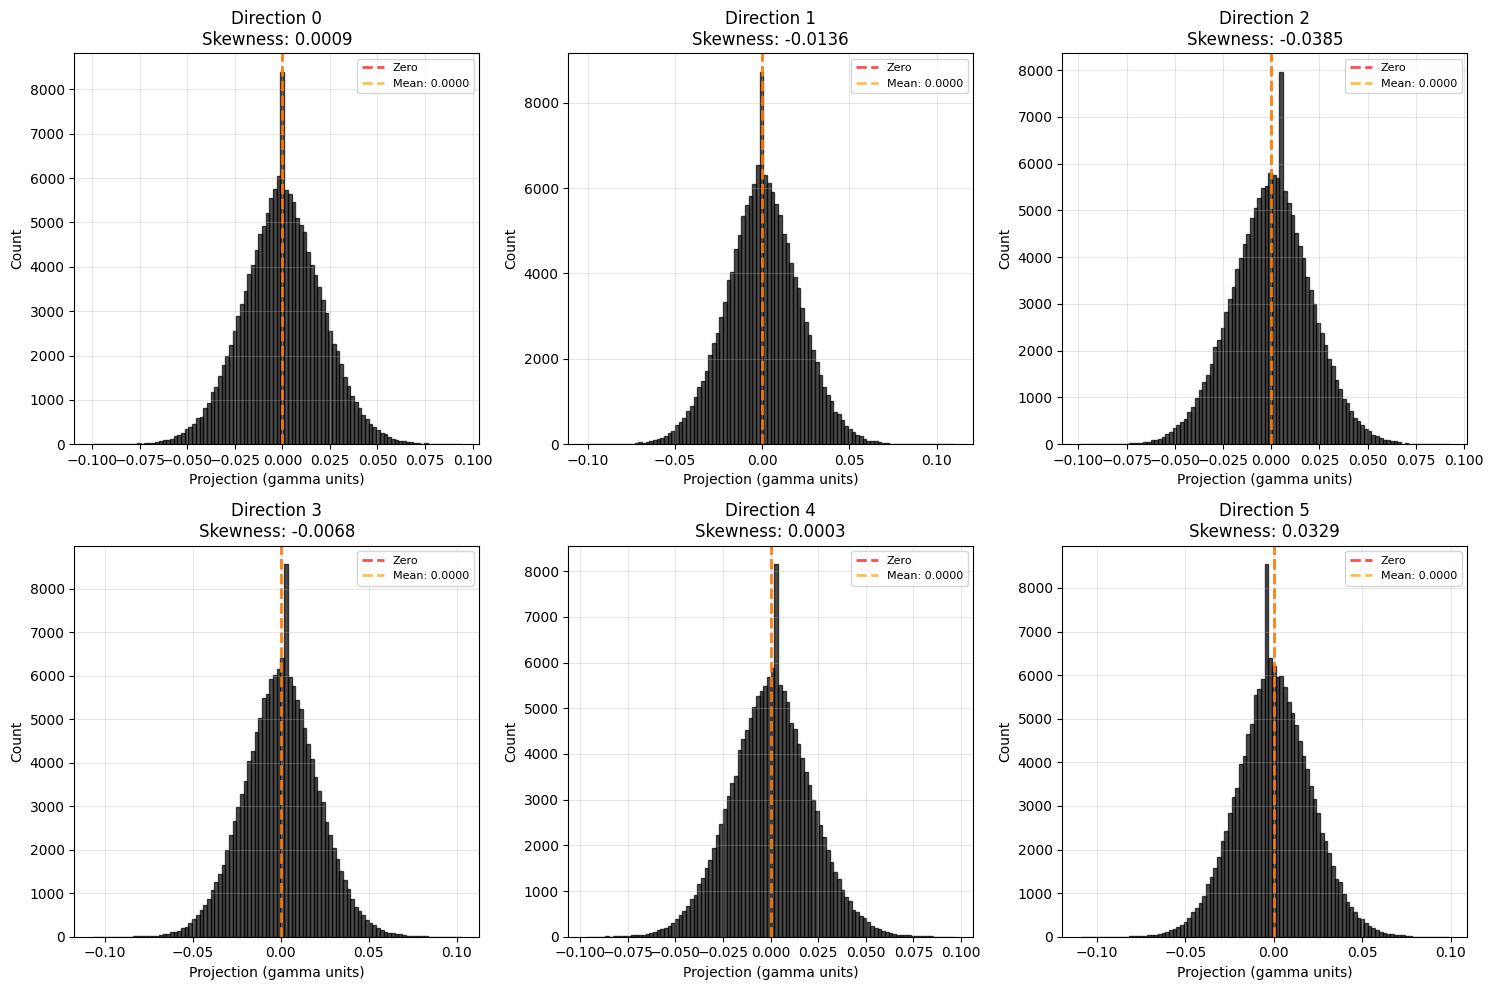


Interpretation:
- If shell: All histograms should be symmetric around zero (skewness ≈ 0)
- If offset blob: At least one direction shows strong asymmetry (skewness >> 0 or << 0)


In [22]:
# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=100)
axes = axes.flatten()

for i in range(NUM_RANDOM_DIRECTIONS):
    ax = axes[i]
    proj = projections[:, i].cpu().numpy()
    
    # Plot histogram
    ax.hist(proj, bins=NUM_BINS, color='black', alpha=0.7, edgecolor='black')
    
    # Add vertical line at zero
    ax.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Zero')
    
    # Add mean line
    mean_proj = proj.mean()
    ax.axvline(mean_proj, color='orange', linestyle='--', linewidth=2, alpha=0.7, 
               label=f'Mean: {mean_proj:.4f}')
    
    # Statistics
    std_proj = proj.std()
    skewness = ((proj - mean_proj) ** 3).mean() / (std_proj ** 3)
    
    ax.set_xlabel('Projection (gamma units)')
    ax.set_ylabel('Count')
    ax.set_title(f'Direction {i}\nSkewness: {skewness:.4f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- If shell: All histograms should be symmetric around zero (skewness ≈ 0)")
print("- If offset blob: At least one direction shows strong asymmetry (skewness >> 0 or << 0)")

## Step 6: Quantitative Analysis

In [23]:
# Compute statistics for each direction
print("Projection statistics for each random direction:\n")
print(f"{'Dir':<5} {'Mean':<10} {'Std':<10} {'Skewness':<12} {'Min':<10} {'Max':<10}")
print("-" * 60)

for i in range(NUM_RANDOM_DIRECTIONS):
    proj = projections[:, i]
    mean_proj = proj.mean().item()
    std_proj = proj.std().item()
    skewness = ((proj - mean_proj) ** 3).mean().item() / (std_proj ** 3)
    min_proj = proj.min().item()
    max_proj = proj.max().item()
    
    print(f"{i:<5} {mean_proj:<10.6f} {std_proj:<10.6f} {skewness:<12.6f} {min_proj:<10.4f} {max_proj:<10.4f}")

print("\nIf all skewness values are close to 0: Strong evidence for shell structure.")
print("If any skewness is large (|skew| > 0.5): Evidence for offset blob.")

Projection statistics for each random direction:

Dir   Mean       Std        Skewness     Min        Max       
------------------------------------------------------------
0     0.000000   0.020688   0.000879     -0.0997    0.0938    
1     -0.000000  0.020763   -0.013621    -0.1007    0.1105    
2     0.000000   0.020556   -0.038455    -0.0988    0.0920    
3     0.000000   0.020869   -0.006808    -0.1071    0.1024    
4     0.000000   0.021023   0.000318     -0.0966    0.0968    
5     0.000000   0.020876   0.032886     -0.1092    0.0989    

If all skewness values are close to 0: Strong evidence for shell structure.
If any skewness is large (|skew| > 0.5): Evidence for offset blob.


## Summary

We projected the token cloud onto random directions and examined the signed distributions.

**Shell structure:** All projections symmetric around zero (skewness ≈ 0, mean ≈ 0)  
**Offset blob:** At least one direction shows strong asymmetry

Based on the plots and statistics above, which hypothesis is supported?